In [1]:
import torch
from Retrival_Dino_Salad.model import SaladFaissGPSDB
from preprocess import CampusGPSDataset, GPSRectNorm
import torchvision.transforms.v2 as v2


# Extract Train Test

In [4]:
from torch.utils.data import DataLoader, random_split 
transform = v2.Compose([
    v2.Resize((4004, 3010), interpolation=v2.InterpolationMode.BILINEAR),
    v2.Resize((294,224), interpolation=v2.InterpolationMode.BILINEAR),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

GPS_norm = GPSRectNorm()
full_dataset = CampusGPSDataset(csv_path="data\photo_locations.csv", image_dir="data\indexed_photos", transform=transform, gps_normalizer=GPS_norm)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
model = torch.hub.load("serizba/salad", "dinov2_salad")


Using cache found in C:\Users\PC/.cache\torch\hub\serizba_salad_main
c:\Users\PC\anaconda3\envs\Image2GPS\lib\site-packages\lightning_fabric\__init__.py:40: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
Using cache found in C:\Users\PC/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\PC/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\PC/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\PC/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.war

# Train Phase

In [5]:
# 1) Load model
db = SaladFaissGPSDB(model, use_cosine=True, normalize=True)
# 2) Build database from train loader (must yield images + gps tensor [B,2])
db.build_from_loader(train_loader)

# 3) Save index + gps/meta
db.save("salad_faiss_db_norm")


0it [00:01, ?it/s]


KeyboardInterrupt: 

In [6]:
# Load later (possibly after restarting kernel)
db2 = SaladFaissGPSDB.load("salad_faiss_db_norm", model=model)

In [ ]:
import numpy as np
from math import radians, sin, cos, sqrt, atan2
from tqdm import tqdm

# Haversine distance in METERS
def haversine_m(lat1, lon1, lat2, lon2):
    R = 6371000.0  # meters
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

def evaluate_gps_meters(db, dataset, k=5, weighted=True, max_samples=None):
    errors_m = []

    n = len(dataset) if max_samples is None else min(len(dataset), max_samples)
    for i in tqdm(range(n)):
        img, gt_gps = dataset[i]
        gt_lat, gt_lon = gt_gps.tolist()

        pred_lat, pred_lon = db.predict_gps(img, k=k, weighted=weighted)
        err = haversine_m(gt_lat, gt_lon, pred_lat, pred_lon)
        errors_m.append(err)

    errors_m = np.array(errors_m, dtype=np.float64)

    thresholds = [10, 25, 50, 100, 250, 500, 1000]  # meters
    metrics = {
        "mean_m": float(errors_m.mean()),
        "median_m": float(np.median(errors_m)),
        "p90_m": float(np.percentile(errors_m, 90)),
        "p95_m": float(np.percentile(errors_m, 95)),
        "max_m": float(errors_m.max()),
    }
    for t in thresholds:
        metrics[f"within_{t}m_%"] = float((errors_m <= t).mean() * 100.0)

    return metrics, errors_m

metrics, errors_m = evaluate_gps_meters(db2, val_dataset, k=5, weighted=True)

print("📍 Meter-level GPS accuracy:")
for k, v in metrics.items():
    print(f"{k}: {v:.2f}")


  0%|          | 0/121 [00:00<?, ?it/s]


RuntimeError: Index is empty. Add data first.

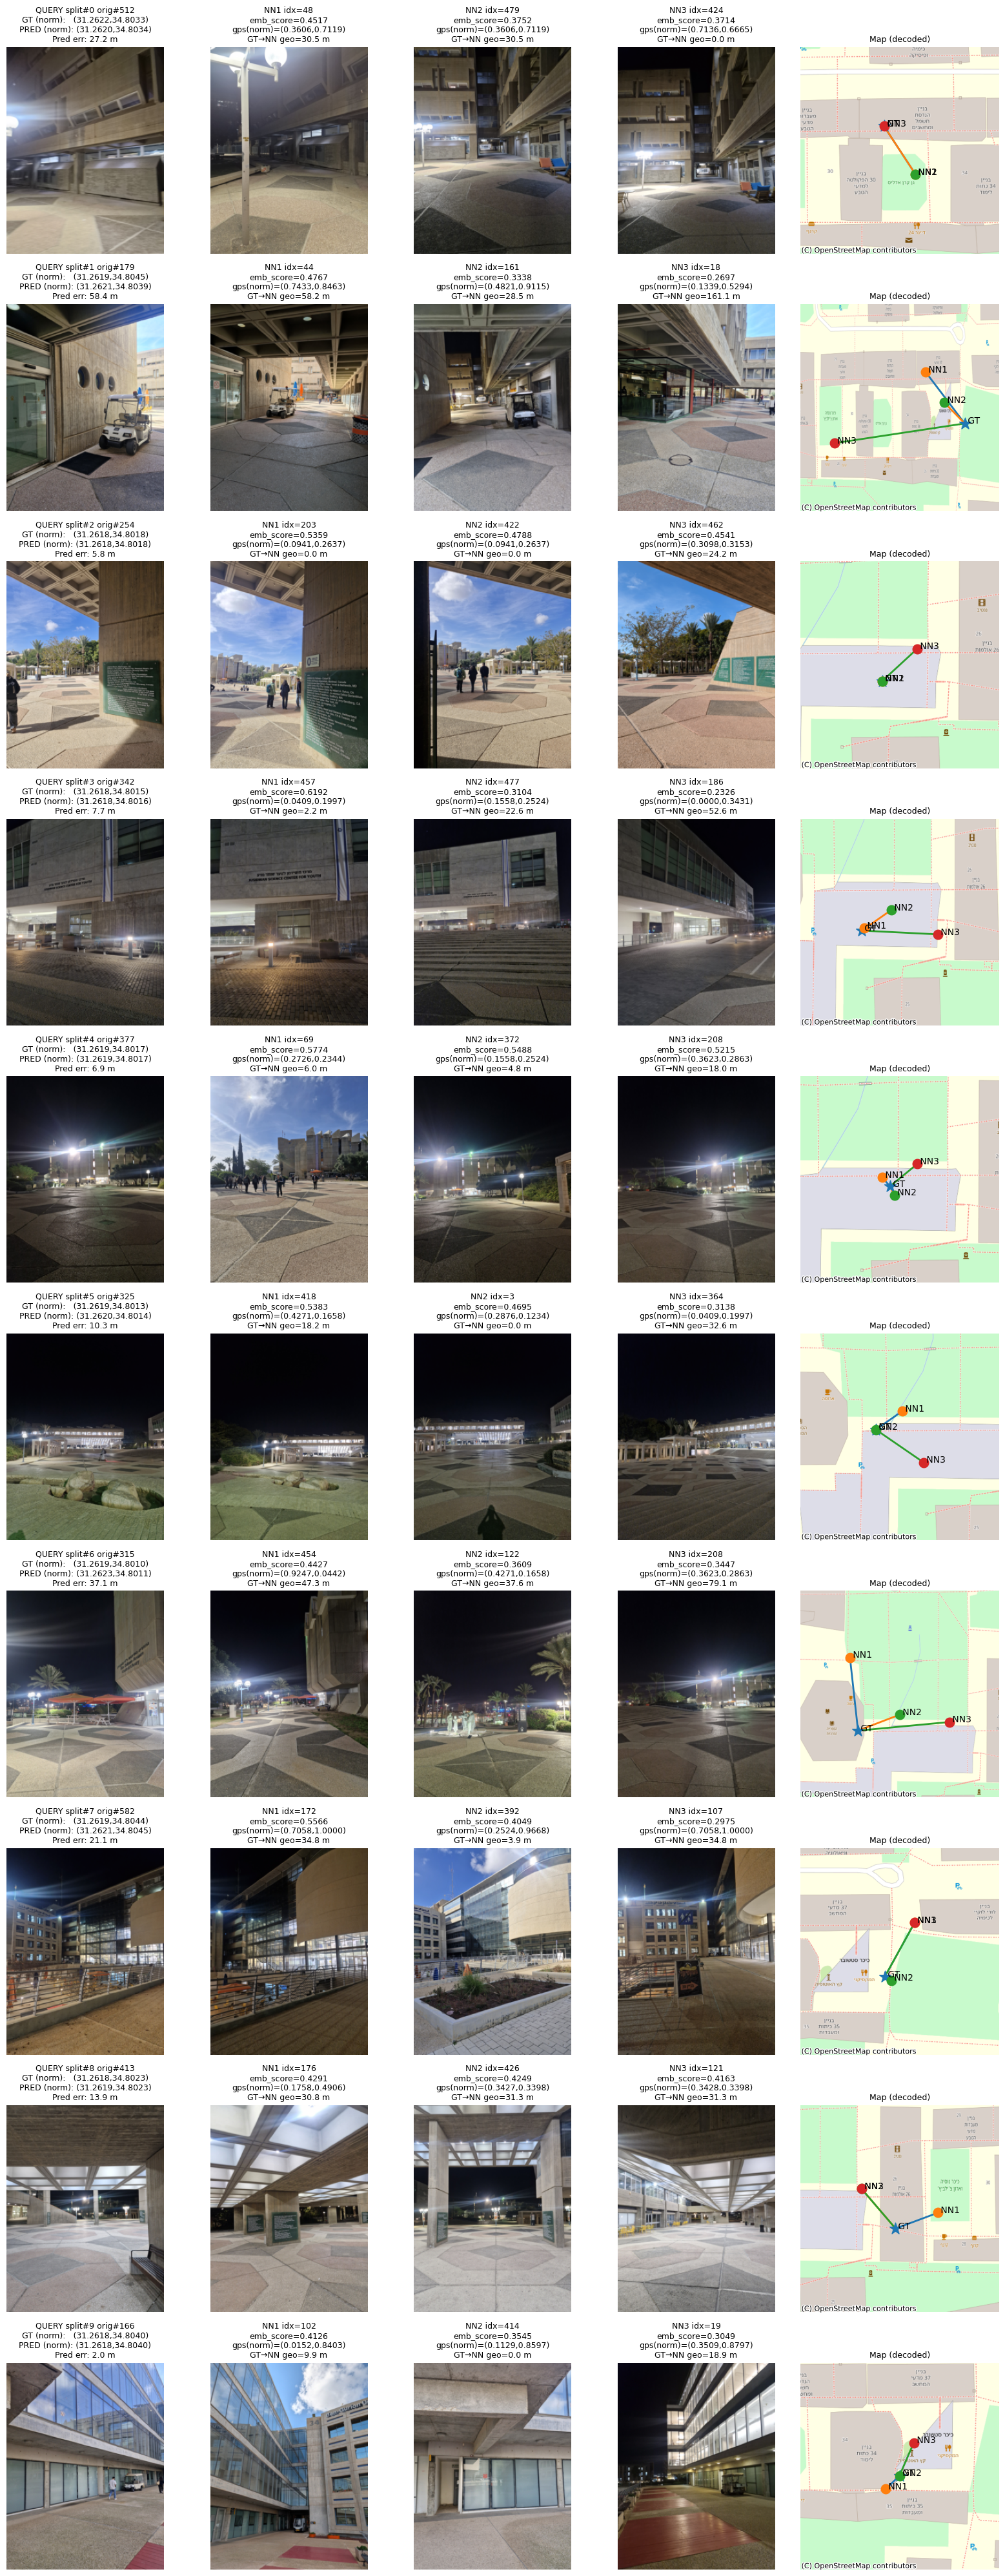

In [20]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from pyproj import Transformer
import contextily as ctx

# Web Mercator transformer (degrees -> meters)
_transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

def latlon_to_mercator(lat_deg, lon_deg):
    x, y = _transformer.transform(lon_deg, lat_deg)
    return x, y

# ----------------------------
# Distance helpers (expects DEGREES!)
# ----------------------------
def haversine_m(lat1_deg, lon1_deg, lat2_deg, lon2_deg):
    from math import radians, sin, cos, sqrt, atan2
    R = 6371000.0
    lat1, lon1, lat2, lon2 = map(radians, [lat1_deg, lon1_deg, lat2_deg, lon2_deg])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

def _to_numpy_image(img, mean=None, std=None):
    if isinstance(img, torch.Tensor):
        x = img.detach().cpu()
        if x.ndim == 3 and x.shape[0] == 3:
            x = x.permute(1, 2, 0)  # HWC
        x = x.float().numpy()
    else:
        x = np.array(img)

    if mean is not None and std is not None:
        mean = np.array(mean, dtype=np.float32).reshape(1, 1, 3)
        std = np.array(std, dtype=np.float32).reshape(1, 1, 3)
        x = x * std + mean

    if x.max() > 1.5:
        x = x / 255.0

    return np.clip(x, 0.0, 1.0).astype(np.float32)

def _format_gps(gps):
    if isinstance(gps, torch.Tensor):
        gps = gps.detach().cpu().tolist()
    return float(gps[0]), float(gps[1])

def _get_match_fields(m):
    idx = getattr(m, "idx", None)
    score = getattr(m, "score", None)
    gps = getattr(m, "gps", None)
    return idx, score, gps

# ----------------------------
# Main visualization
# ----------------------------
def plot_queries_with_topk_matches_and_map(
    db,
    test_dataset,
    train_dataset=None,
    GPS_norm=None,               # MUST provide (has .decode)
    n=5,
    k=3,
    weighted=True,
    mean=None, std=None,
    figsize_per_row=(16, 4),
    pad_m=50,
    zoom=19,
):
    """
    Shows per row:
      [Query image] [NN1] [NN2] [NN3] ... [Map]

    Titles print NORMALIZED GPS only.
    Distances + map use DECODED GPS internally.
    """

    if GPS_norm is None:
        raise ValueError("GPS_norm must be provided (object with .decode(lat_n, lon_n)->(lat_deg, lon_deg))")

    n = min(n, len(test_dataset))
    cols = k + 2  # Query + k matches + Map
    fig = plt.figure(figsize=(figsize_per_row[0], figsize_per_row[1] * n))

    def clamp01(a, b):
        return float(np.clip(a, 0.0, 1.0)), float(np.clip(b, 0.0, 1.0))

    for row in range(n):
        query_img, query_gps = test_dataset[row]

        # GT normalized (what we PRINT)
        gt_lat_n, gt_lon_n = _format_gps(query_gps)
        gt_lat_n, gt_lon_n = clamp01(gt_lat_n, gt_lon_n)

        # GT decoded (what we USE for meters/map)
        gt_lat_d, gt_lon_d = GPS_norm.decode(gt_lat_n, gt_lon_n)

        # Original idx in full_dataset if Subset
        orig_idx = test_dataset.indices[row] if hasattr(test_dataset, "indices") else row

        # Predict normalized (db built on normalized gps)
        with torch.no_grad():
            pred_lat_n, pred_lon_n = db.predict_gps(query_img, k=max(k, 5), weighted=weighted)
        pred_lat_n, pred_lon_n = clamp01(float(pred_lat_n), float(pred_lon_n))
        pred_lat_d, pred_lon_d = GPS_norm.decode(pred_lat_n, pred_lon_n)

        pred_err_m = haversine_m(gt_lat_d, gt_lon_d, pred_lat_d, pred_lon_d)

        # Query panel
        ax = plt.subplot(n, cols, row * cols + 1)
        ax.imshow(_to_numpy_image(query_img, mean=mean, std=std))
        ax.axis("off")
        ax.set_title(
            f"QUERY split#{row} orig#{orig_idx + 1}\n"
            f"GT (norm):   ({gt_lat_d:.4f},{gt_lon_d:.4f})\n"
            f"PRED (norm): ({pred_lat_d:.4f},{pred_lon_d:.4f})\n"
            f"Pred err: {pred_err_m:.1f} m",
            fontsize=9
        )

        # Get matches (their gps is normalized)
        matches = db.query_image(query_img, k=k)

        # Collect decoded mercator points for map bounds
        gx, gy = latlon_to_mercator(gt_lat_d, gt_lon_d)
        all_x = [gx]
        all_y = [gy]
        nn_xy = []

        # NN panels
        for j in range(k):
            axm = plt.subplot(n, cols, row * cols + 1 + (j + 1))

            if j >= len(matches):
                axm.axis("off")
                axm.set_title(f"NN{j+1}\n(no match)", fontsize=9)
                continue

            m = matches[j]
            idx, score, mgps = _get_match_fields(m)

            # Match gps normalized for PRINT, decoded for meters/map
            if mgps is not None:
                mlat_n, mlon_n = _format_gps(mgps)
                mlat_n, mlon_n = clamp01(mlat_n, mlon_n)
                mlat_d, mlon_d = GPS_norm.decode(mlat_n, mlon_n)
                geo_m = haversine_m(gt_lat_d, gt_lon_d, mlat_d, mlon_d)

                x, y = latlon_to_mercator(mlat_d, mlon_d)
                nn_xy.append((x, y))
                all_x.append(x)
                all_y.append(y)
            else:
                mlat_n = mlon_n = None
                geo_m = None

            # Show match image if possible
            if train_dataset is not None and idx is not None:
                try:
                    mimg, _ = train_dataset[idx]
                    axm.imshow(_to_numpy_image(mimg, mean=mean, std=std))
                    axm.axis("off")
                except Exception:
                    axm.axis("off")
                    axm.text(0.5, 0.5, f"train_dataset[{idx}] failed", ha="center", va="center")
            else:
                axm.axis("off")
                axm.text(0.5, 0.5, "No train image", ha="center", va="center")

            score_str = "NA" if score is None else f"{float(score):.4f}"
            geo_str = "NA" if geo_m is None else f"{geo_m:.1f} m"
            gps_norm_str = "NA" if mlat_n is None else f"({mlat_n:.4f},{mlon_n:.4f})"

            axm.set_title(
                f"NN{j+1} idx={idx}\n"
                f"emb_score={score_str}\n"
                f"gps(norm)={gps_norm_str}\n"
                f"GT→NN geo={geo_str}",
                fontsize=9
            )

        # Map panel (decoded only)
        ax_map = plt.subplot(n, cols, row * cols + cols)

        # bounds in meters (EPSG:3857)
        ax_map.set_xlim(min(all_x) - pad_m, max(all_x) + pad_m)
        ax_map.set_ylim(min(all_y) - pad_m, max(all_y) + pad_m)

        ctx.add_basemap(ax_map, source=ctx.providers.OpenStreetMap.Mapnik, zoom=zoom)

        ax_map.scatter(gx, gy, s=180, marker="*", zorder=5)
        ax_map.text(gx, gy, " GT", fontsize=10, zorder=6)

        for i, (x, y) in enumerate(nn_xy, 1):
            ax_map.scatter(x, y, s=110, zorder=5)
            ax_map.plot([gx, x], [gy, y], linewidth=2, zorder=4)
            ax_map.text(x, y, f" NN{i}", fontsize=10, zorder=6)

        ax_map.set_title("Map (decoded)", fontsize=9)
        ax_map.axis("off")

    plt.tight_layout()
    plt.show()

# ----------------------------
# Example usage:
# ----------------------------
plot_queries_with_topk_matches_and_map(
    db=db2,
    test_dataset=val_dataset,
    train_dataset=train_dataset,
    GPS_norm=GPS_norm,  # <-- your normalizer object
    n=10,
    k=3,
    weighted=True,
    mean=(0.485, 0.456, 0.406),
    std=(0.229, 0.224, 0.225),
    pad_m=50,
    zoom=19
)


In [21]:
from data.extract_gps import extract_gps


print(extract_gps(r"C:\Users\PC\Desktop\Works\semester g\Deep\Image2GPS-Deep\data\temp\20260113_152942.jpg"))
extract_gps(r"data\indexed_photos\179.jpg")

(31.2613553, 34.802557199999995)


(31.261939399722223, 34.80447509972222)

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt


def plot_query_and_nn_map(db, test_dataset, idx=0, k=3):
    """
    Plots a lat/lon scatter "mini-map" for:
      - query (ground truth)
      - query prediction (optional)
      - k nearest neighbors GPS locations

    Assumes:
      - test_dataset[idx] -> (img, gps) with gps=[lat,lon]
      - db.query_image(img,k) -> list of matches with .gps and optional .score
      - db.predict_gps(img, ...) -> (lat, lon)
    """

    img, gt_gps = test_dataset[idx]
    gt_lat, gt_lon = gt_gps.detach().cpu().tolist() if isinstance(gt_gps, torch.Tensor) else gt_gps

    # NN matches
    matches = db.query_image(img, k=k)
    nn_lats, nn_lons, nn_scores = [], [], []
    for m in matches:
        mgps = getattr(m, "gps", None)
        if mgps is None:
            continue
        mlat, mlon = mgps.detach().cpu().tolist() if isinstance(mgps, torch.Tensor) else mgps
        nn_lats.append(float(mlat))
        nn_lons.append(float(mlon))
        nn_scores.append(getattr(m, "score", None))

    # Optional prediction point
    with torch.no_grad():
        pred_lat, pred_lon = db.predict_gps(img, k=max(5, k), weighted=True)

    # ---- Plot ----
    plt.figure(figsize=(7, 7))

    # Neighbors
    if len(nn_lats) > 0:
        plt.scatter(nn_lons, nn_lats, marker="o", label="Nearest neighbors (train)", s=80)
        # label each neighbor with rank
        for i, (lo, la) in enumerate(zip(nn_lons, nn_lats), start=1):
            plt.text(lo, la, f"  NN{i}", fontsize=10)

    # Query GT
    plt.scatter([gt_lon], [gt_lat], marker="*", label="Query GT (test)", s=220)

    # Query prediction
    plt.scatter([pred_lon], [pred_lat], marker="x", label="Query predicted", s=120)

    # Nice view: zoom around query + neighbors
    all_lats = [gt_lat] + nn_lats + [float(pred_lat)]
    all_lons = [gt_lon] + nn_lons + [float(pred_lon)]
    lat_min, lat_max = min(all_lats), max(all_lats)
    lon_min, lon_max = min(all_lons), max(all_lons)

    # add a small margin
    lat_pad = (lat_max - lat_min) * 0.25 + 1e-6
    lon_pad = (lon_max - lon_min) * 0.25 + 1e-6
    plt.xlim(lon_min - lon_pad, lon_max + lon_pad)
    plt.ylim(lat_min - lat_pad, lat_max + lat_pad)

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Query test sample #{idx} + {k} nearest neighbors")
    plt.grid(True)
    plt.legend()
    plt.show()
#plot_query_and_nn_map(db2, val_dataset, idx=0, k=3)



In [ ]:
import folium
import torch


def plot_query_and_nn_real_map(
    db,
    test_dataset,
    idx=0,
    k=3,
    weighted=True,
    out_html="nn_map.html",
    zoom_start=18
):
    """
    Creates an interactive real map (Folium) with:
      - Query GT (star marker)
      - Query prediction (blue marker)
      - k nearest neighbors (numbered markers)
      - Lines from query GT to each NN

    Saves to out_html and also returns the folium.Map object.
    """

    # --- get query ---
    img, gt_gps = test_dataset[idx]
    if isinstance(gt_gps, torch.Tensor):
        gt_lat, gt_lon = gt_gps.detach().cpu().tolist()
    else:
        gt_lat, gt_lon = gt_gps

    # --- predict gps ---
    with torch.no_grad():
        pred_lat, pred_lon = db.predict_gps(img, k=max(k, 5), weighted=weighted)

    # --- nearest neighbors ---
    matches = db.query_image(img, k=k)

    nn_points = []
    for rank, m in enumerate(matches, start=1):
        mgps = getattr(m, "gps", None)
        if mgps is None:
            continue
        if isinstance(mgps, torch.Tensor):
            mlat, mlon = mgps.detach().cpu().tolist()
        else:
            mlat, mlon = mgps
        score = getattr(m, "score", None)
        midx = getattr(m, "idx", None)
        nn_points.append((rank, float(mlat), float(mlon), score, midx))

    # --- build map centered at GT ---
    m = folium.Map(location=[gt_lat, gt_lon], zoom_start=zoom_start, control_scale=True)

    # Query GT marker
    folium.Marker(
        location=[gt_lat, gt_lon],
        popup=f"Query GT (test #{idx})\n({gt_lat:.6f}, {gt_lon:.6f})",
        tooltip="Query GT",
        icon=folium.Icon(color="red", icon="star")
    ).add_to(m)

    # Prediction marker
    folium.Marker(
        location=[float(pred_lat), float(pred_lon)],
        popup=f"Prediction\n({float(pred_lat):.6f}, {float(pred_lon):.6f})",
        tooltip="Prediction",
        icon=folium.Icon(color="blue", icon="info-sign")
    ).add_to(m)

    # Neighbors markers + lines
    for rank, lat, lon, score, midx in nn_points:
        popup = f"NN{rank} idx={midx} score={score}\n({lat:.6f}, {lon:.6f})"
        folium.Marker(
            location=[lat, lon],
            popup=popup,
            tooltip=f"NN{rank}",
            icon=folium.Icon(color="green", icon="ok-sign")
        ).add_to(m)

        # line from GT to neighbor
        folium.PolyLine(
            locations=[[gt_lat, gt_lon], [lat, lon]],
            weight=3,
            opacity=0.8
        ).add_to(m)

    # Also line from GT to prediction
    folium.PolyLine(
        locations=[[gt_lat, gt_lon], [float(pred_lat), float(pred_lon)]],
        weight=3,
        opacity=0.8
    ).add_to(m)

    m.save(out_html)
    print(f"Saved map to: {out_html}  (open it in your browser)")
    return m

plot_query_and_nn_real_map(db2, val_dataset, idx=1, k=2, out_html="nn_map_0.html")


Saved map to: nn_map_0.html  (open it in your browser)
